In [149]:
import pathlib as plb
import nibabel as nib
import numpy as np
import sys, os
from tqdm import tqdm
import scipy
from scipy import ndimage
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
nii_path = plb.Path('/gpfs/fs0/data/stanford_data/master/')

!ls $nii_path

annotation_for_train  image_for_train_processed


In [151]:
key = 'SUV'
root = plb.Path(nii_path/plb.Path('image_for_train_processed'))
patient_dirs = list(root.glob('*{}*.nii.gz'.format(key)))
print(patient_dirs[:3])
print(patient_dirs[0].name)


[PosixPath('/gpfs/fs0/data/stanford_data/master/image_for_train_processed/N80_SUV2LAVA_deformed.nii.gz'), PosixPath('/gpfs/fs0/data/stanford_data/master/image_for_train_processed/N74_SUV2LAVA_deformed.nii.gz'), PosixPath('/gpfs/fs0/data/stanford_data/master/image_for_train_processed/N82_SUV2LAVA_deformed.nii.gz')]
N80_SUV2LAVA_deformed.nii.gz


In [150]:
dftest = pd.read_csv('/gpfs/fs0/data/stanford_data/Test_IDs.csv')
dftest.head(2)

,ID
0,N9
1,N10


In [157]:
study_IDs = dftest['ID'].tolist()
print(study_IDs)
full_nifty_paths = []
for study_id in study_IDs:
    study_path = list(root.glob('{}_*.nii.gz'.format(study_id)))
    full_nifty_paths.extend(study_path)
print(full_nifty_paths[3])

['N9', 'N10', 'N13', 'N29', 'N32', 'N37', 'N38', 'N39', 'N42', 'N49', 'N55', 'N57', 'N71', 'N72', 'N80', 'N82', 'N85', 'N86', 'N47', 'N67', 'N15']
/gpfs/fs0/data/stanford_data/master/image_for_train_processed/N10_LAVA_space3.nii.gz


In [8]:
pet  = nib.load(nii_path/plb.Path('image_for_train_processed/N9_SUV2LAVA_deformed.nii.gz'))
seg  = nib.load(nii_path/plb.Path('annotation_for_train/N9_space3.nii.gz'))

In [9]:
pet_img = pet.get_fdata()
seg_img = seg.get_fdata()
print(pet_img.shape)
print(seg_img.shape)

(140, 140, 575)
(140, 140, 575)


In [41]:
print(pet.header) 

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 140 140 575   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1. 3. 3. 3. 1. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'FSL5.0'
aux_file        : b''
qform_code      : aligned
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 1.0
qoffset_x       : 208.918
qoffset_y       : 223.028
qoffset_z       : -1596.5403
srow_x          : [ -3.      0. 

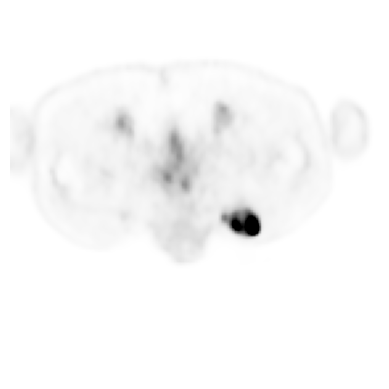

In [27]:
idx = 280
fig,ax=plt.subplots()
ax.set_axis_off()
plt.imshow(np.rot90(pet_img[:,:,idx].copy()),cmap='Greys', vmax=5)

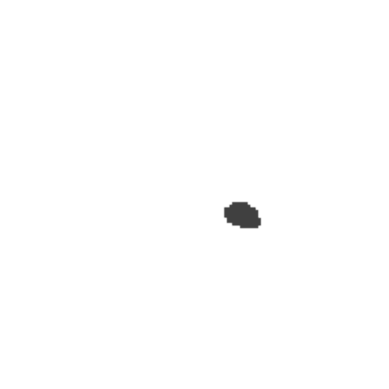

In [28]:
# for i in range(seg_img.shape[2]):
#     if seg_img[:,:,i].any():
#         print(i)
fig,ax=plt.subplots()
ax.set_axis_off()
plt.imshow(np.rot90(seg_img[:,:,idx].copy()),cmap='Greys', vmax=5)

In [125]:
# adapted this so doesn't need to crop/reschale again.
def create_mipNIFTI_from_3D(img, nb_image=48):
    ls_mip=[]
    
    img_data=img.get_fdata()
    shape = img_data.shape
    print(shape)
    diag = int(np.ceil(np.sqrt(np.square(shape[0])+np.square(shape[1]))))
    max_width = max([450, diag])
    target_shape = (shape[2], max_width) # (y_, x_)
    print(target_shape)

    #Modified nifti header saving useful axial slices information
    # Can't seem to create new fields but can use existing fields to store other information...
    header = img.header.copy()
    liver_idx = img_data.shape[-1]//2
    suv_liver = img_data[:,:,liver_idx].squeeze().max()
    suv_brain = img_data[:,:,-1].squeeze().max()
#     print('Liver SUV max', suv_liver)
    header['intent_p1'] = suv_liver
    header['intent_p2'] = suv_brain
    header['intent_p3'] = img_data.max()
    # Can't store too many letters...
    header['intent_name'] = b'liver;brain;max'
    
#     print('Interpolating')
    img_data+=1e-5
    for angle in tqdm(np.linspace(0,360,nb_image)):
        #ls_slice=[]
        # This step is slow: https://stackoverflow.com/questions/14163211/rotation-in-python-with-ndimage
#         vol_angle= scipy.ndimage.interpolation.rotate(img_data,angle,order=0)
        vol_angle = scipy.ndimage.rotate(img_data,angle,order=0)
        
        MIP=np.amax(vol_angle,axis=1)
        MIP-=1e-5
        MIP[MIP<1e-5]=0
        MIP=np.flipud(MIP.T)
        MIP=to_shape(MIP, target_shape)
        ls_mip.append(MIP)
#         print('angle:', angle, MIP.shape)
    
    new_data = np.dstack(ls_mip) #shape [:,:,i]
    mip_nifti = nib.Nifti1Image(new_data, None, header)
    
    return mip_nifti

# Pad to same shape before stack
def to_shape(a, shape):
    y_, x_ = shape
    y, x = a.shape
    x_pad = abs((x_-x))
    y_pad = abs((y_-y)) # should be 0
    return np.pad(a,((y_pad//2, y_pad//2 + y_pad%2),
                     (x_pad//2, x_pad//2 + x_pad%2)),
                  mode = 'constant') #Default is 0

In [126]:
mip_pet = create_mipNIFTI_from_3D(pet, nb_image=10)

(140, 140, 575)
(575, 450)


100%|███████████████████████████████████████████| 10/10 [00:08<00:00,  1.21it/s]


In [127]:
mip_seg = create_mipNIFTI_from_3D(seg, nb_image=10)

(140, 140, 575)
(575, 450)


100%|███████████████████████████████████████████| 10/10 [00:08<00:00,  1.22it/s]


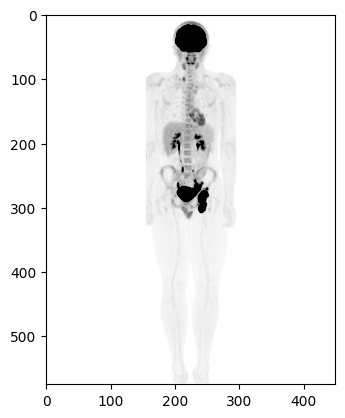

In [128]:
idx = 0
fig,ax=plt.subplots()
# ax.set_axis_off()
plt.imshow(mip_pet.get_fdata()[:,:,idx].copy(),cmap='Greys', vmax=5)

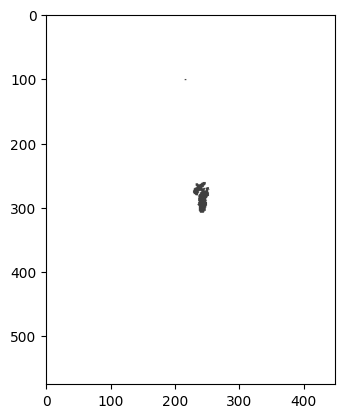

In [129]:
fig,ax=plt.subplots()
# ax.set_axis_off()
plt.imshow(mip_seg.get_fdata()[:,:,idx].copy(),cmap='Greys', vmax=5)